In [130]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed, MultiHeadAttention, Layer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout2D, RepeatVector
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras import metrics
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# data loading
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,theta_norm,Vx_norm,Vy_norm,lane,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0.786530,0.206384,0.659098,0.778120,0.764706,0,0.795350,0.203490
43617,42.246167,-83.563112,0.03,5.02,237.211,0.546,-1.151,-0.30,-0.95,-0.011,0.052,0.785304,0.204631,0.658926,0.771957,0.764706,0,0.787305,0.203073
43667,42.246155,-83.563137,0.03,4.97,237.141,0.579,-1.066,0.35,0.15,-0.034,0.155,0.784089,0.202890,0.658731,0.764253,0.764706,0,0.788982,0.203170
43717,42.246143,-83.563163,0.03,4.93,237.076,0.566,-0.967,0.66,-0.29,-0.037,0.253,0.782877,0.201164,0.658551,0.758089,0.764706,0,0.794082,0.195338
43767,42.246131,-83.563188,0.02,4.90,236.990,0.515,-0.921,-0.25,0.01,0.162,0.064,0.781676,0.199454,0.658312,0.753467,0.705882,0,0.791014,0.203958


In [139]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)

(500, 77, 5)
(500, 77, 2)


In [5]:
# selecting max_y_len and max_x_len
max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

max_x_len, max_y_len

(77, 3822)

In [6]:
embedding_dim = 128
latent_dim = 300

In [265]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(embedding_dim,1), 
                               initializer='normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(77,1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        #e = K.squeeze(e, axis=-1)  
        e = keras.layers.Flatten()(e)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        #alpha = K.expand_dims(alpha, axis=-1)
        temp=RepeatVector(128)(alpha)
        temp=keras.layers.Permute([2, 1])(temp)
        # multiply weight with lstm layer o/p
        output = keras.layers.Multiply()([x, temp])
        # Get the attention adjusted output state
        output = keras.layers.Lambda(lambda values: K.sum(values, axis=1))(output)
        # Pass output to step 4 and 'a' to any nice display
        # Compute the context vector
       # context = x * alpha
       # context = K.sum(context, axis=1)
        return output

In [268]:
def create_LSTM(latent_dim, dense_units, return_sequences, input_shape, activation):
    # dense layer of spatial embedding
    x_train_input = Input(shape=(input_shape))
    x_spatial_embedd1 = Dense(256)
    x_spatial_embedd2 = Dense(embedding_dim)

    # x_train_temp_input = Input(shape=(77,))
    # temporal embedding
    # x_temporal_embedd = Embedding(max_x_len+1, embedding_dim, input_length=max_x_len+1, trainable=True) 

    # combining two features to get spatio-temporal feature representation of input trajectory
    # x_h_st = Add()([x_spatial_embedd2(x_spatial_embedd1(x_train_input)), x_temporal_embedd(x_train_temp_input)])
    x_h_st = x_spatial_embedd2(x_spatial_embedd1(x_train_input))


    encoder_l1 = LSTM(embedding_dim,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(x_h_st)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = LSTM(embedding_dim, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #print(encoder_outputs2[0].shape)
    decoder_inputs = RepeatVector(77)(encoder_outputs2[0])
    #decoder_layer = keras.layers[-1]
    decoder_l1 = LSTM(embedding_dim, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
    decoder_l2 = LSTM(embedding_dim, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
    attention_layer = attention()(decoder_l2[0])
    decoder_outputs2 = Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    print(decoder_l2.shape)  
    #decoder_outputs2 = K.squeeze(decoder_outputs2, axis=-1) 
    model_e2d2 = Model(x_train_input, decoder_outputs2)
    model_e2d2.compile(loss='mse', optimizer='adam', metrics=[metrics.mean_absolute_percentage_error])
    return model_e2d2

model_LSTM = create_LSTM(latent_dim=latent_dim, dense_units=2, return_sequences=True, input_shape=(max_x_len,5), activation='tanh')
model_LSTM.summary()

(None, 77, 128)
Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_200 (InputLayer)         [(None, 77, 5)]      0           []                               
                                                                                                  
 dense_350 (Dense)              (None, 77, 256)      1536        ['input_200[0][0]']              
                                                                                                  
 dense_351 (Dense)              (None, 77, 128)      32896       ['dense_350[0][0]']              
                                                                                                  
 lstm_495 (LSTM)                [(None, 77, 128),    131584      ['dense_351[0][0]']              
                                 (None, 128),                              

In [269]:
# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll)
print(x_train.shape)

# x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
# y_train = np.asarray(y_ll)
y_train = np.asarray(y_gps_ll)
print(y_train.shape)

# reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

history = model_LSTM.fit(
    x_train, y_train,
    validation_split = 0.1,
    epochs = 500, batch_size = 77, callbacks=[es]
)

(500, 77, 5)
(500, 77, 2)
Epoch 1/500
6/6 [==============================] - 9s 458ms/step - loss: 0.2029 - mean_absolute_percentage_error: 85117.1797 - val_loss: 0.1501 - val_mean_absolute_percentage_error: 16291.5898
Epoch 2/500
6/6 [==============================] - 1s 196ms/step - loss: 0.1414 - mean_absolute_percentage_error: 102787.2734 - val_loss: 0.1228 - val_mean_absolute_percentage_error: 26624.5918
Epoch 3/500
6/6 [==============================] - 1s 197ms/step - loss: 0.1314 - mean_absolute_percentage_error: 90886.8672 - val_loss: 0.1235 - val_mean_absolute_percentage_error: 22561.1816
Epoch 4/500
6/6 [==============================] - 1s 197ms/step - loss: 0.1353 - mean_absolute_percentage_error: 98025.3750 - val_loss: 0.1272 - val_mean_absolute_percentage_error: 28311.4863
Epoch 5/500
6/6 [==============================] - 1s 197ms/step - loss: 0.1274 - mean_absolute_percentage_error: 87848.1719 - val_loss: 0.1217 - val_mean_absolute_percentage_error: 23955.9590
Epoch 6/

6/6 [==============================] - 1s 201ms/step - loss: 0.1244 - mean_absolute_percentage_error: 89797.9844 - val_loss: 0.1203 - val_mean_absolute_percentage_error: 26533.8164
Epoch 44/500
6/6 [==============================] - 1s 202ms/step - loss: 0.1249 - mean_absolute_percentage_error: 87262.3594 - val_loss: 0.1228 - val_mean_absolute_percentage_error: 28209.5879
Epoch 45/500
6/6 [==============================] - 1s 200ms/step - loss: 0.1241 - mean_absolute_percentage_error: 90954.1953 - val_loss: 0.1226 - val_mean_absolute_percentage_error: 28391.8438
Epoch 46/500
6/6 [==============================] - 1s 198ms/step - loss: 0.1245 - mean_absolute_percentage_error: 89910.5469 - val_loss: 0.1214 - val_mean_absolute_percentage_error: 28092.6172
Epoch 47/500
6/6 [==============================] - 1s 199ms/step - loss: 0.1246 - mean_absolute_percentage_error: 90168.8125 - val_loss: 0.1232 - val_mean_absolute_percentage_error: 27912.6797
Epoch 48/500
6/6 [=========================

6/6 [==============================] - 1s 199ms/step - loss: 0.1244 - mean_absolute_percentage_error: 88506.8438 - val_loss: 0.1219 - val_mean_absolute_percentage_error: 28277.2734
Epoch 86/500
6/6 [==============================] - 1s 199ms/step - loss: 0.1243 - mean_absolute_percentage_error: 90210.0234 - val_loss: 0.1240 - val_mean_absolute_percentage_error: 28809.9590
Epoch 87/500
6/6 [==============================] - 1s 200ms/step - loss: 0.1243 - mean_absolute_percentage_error: 92066.0859 - val_loss: 0.1219 - val_mean_absolute_percentage_error: 27987.9238
Epoch 88/500
6/6 [==============================] - 1s 199ms/step - loss: 0.1246 - mean_absolute_percentage_error: 86901.9297 - val_loss: 0.1216 - val_mean_absolute_percentage_error: 28082.1738
Epoch 89/500
6/6 [==============================] - 1s 199ms/step - loss: 0.1242 - mean_absolute_percentage_error: 89781.9844 - val_loss: 0.1231 - val_mean_absolute_percentage_error: 28466.4395
Epoch 90/500
6/6 [=========================

### loading and saving model

- mode/autoencode_v1: baseline model to be improved, epoch=100, val_loss~=800

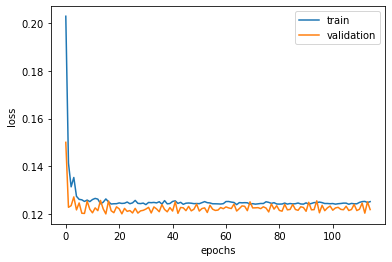

In [274]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

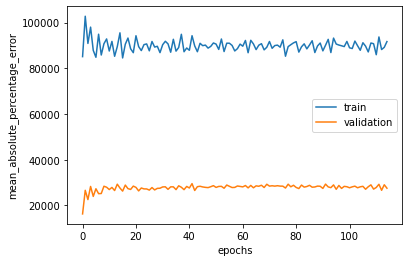

In [275]:
plt.plot(history.history['mean_absolute_percentage_error'], label='train')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('mean_absolute_percentage_error')
plt.legend()
plt.show()

In [276]:
sample = 2

y_pred = model_LSTM.predict(
    [x_train[sample].reshape(1, max_x_len, 5)]
    ).reshape(max_x_len, 2)

y_pred.shape, x_train[sample].shape

((77, 2), (77, 5))

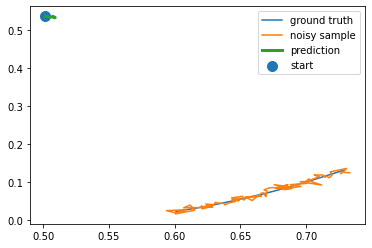

In [277]:
plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], label='noisy sample')
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3)
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=100)

plt.legend()
plt.show()